# Notebook 2/2: EDA & Modeling

### Contents:
* [Data import & initial EDA](#Data-import-&-initial-EDA)
* [Aggregate visualizations](#Aggregate-visualizations)
    * [Canceled calls](#Canceled-calls)
    * [Severity level codes](#Severity-level-codes)
* [Mapping dispatch activity by zipcode](#Mapping-dispatch-activity-by-zipcode)
* [K-Modes Clustering...](#K-Modes-Clustering...)

## Library import

In [541]:
import pandas as pd
import dask.dataframe as dd

import datetime as dt
import numpy as np
import geopandas as gpd
import scipy
import shapely
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

import matplotlib.colors as mcolors

In [53]:
pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 110)

## Data import & initial EDA

### Context:
Many volunteer EMS companies in NYC identify emergency calls by listening in on the public 911 dispatches and respond to those calls alongside the 911 units. The 911 units are frequently working 12-hr shifts, often with mandatory overtime, and don't necessarily mind handing the patient off to the volunteer units. When this happens, the disposition code referring to the call is given as an 87 (call canceled) or 94 (treated & transferred care). At the same time, not all canceled calls are canceled because of the presence of volunteer units. This notebook will focus on the canceled calls (87 & 94) to determine whether volunteer EMS has a detectable influence on NYC's EMS.

### Read in data as Pandas df

In [54]:
# Read in processed csv file as Pandas df--data not stored in GitHub repository due to large file size
df_concat = pd.read_csv('~/Documents/GA_2019/Projects/EMS_dispatch_evenings.csv', 
                        parse_dates = ['INCIDENT_DATETIME',
                                      'FIRST_ASSIGNMENT_DATETIME',
                                      'FIRST_ACTIVATION_DATETIME',
                                      'FIRST_ON_SCENE_DATETIME',
                                      'FIRST_TO_HOSP_DATETIME',
                                      'FIRST_HOSP_ARRIVAL_DATETIME',
                                      'INCIDENT_CLOSE_DATETIME'])

**Note:** When the full dataset is being processed, all date-time columns are converted from object type to datetime type. But once the resulting dataframe is saved to .csv, this formatting is lost, because spreadsheet-format doesn't preserve data types. Therefore the 'parse_dates' in the above pd.read_csv is required, it reminds the dates of the format they're supposed to be in. The initial function from Notebook 1 was still necessary as a first step because it formatted the dates so that parse_dates could do its thing without issue.

In [55]:
# How does our data look?
df_concat.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
0,183654386,2018-12-31 23:59:46,CARDBR,2,CARDBR,2,2018-12-31 23:59:54,Y,8,2019-01-01 00:00:51,2019-01-01 00:07:27,Y,461.0,453.0,2019-01-01 00:15:08,2019-01-01 00:21:51,2019-01-01 01:00:20,N,82.0,BROOKLYN,K6,11201.0
1,183654385,2018-12-31 23:59:20,MVAINJ,4,MVAINJ,4,2019-01-01 00:01:10,Y,110,2019-01-01 00:02:25,2019-01-01 00:07:19,Y,479.0,369.0,NaT,NaT,2019-01-01 00:19:49,N,91.0,QUEENS,Q3,11416.0
2,183654384,2018-12-31 23:58:45,SICK,6,SICK,6,2019-01-01 00:00:43,Y,118,2019-01-01 00:02:08,2019-01-01 00:14:18,Y,933.0,815.0,2019-01-01 00:23:59,2019-01-01 00:34:07,2019-01-01 01:21:30,N,82.0,QUEENS,Q6,11369.0
3,183654383,2018-12-31 23:58:14,INJMAJ,3,INJMAJ,3,2018-12-31 23:58:22,Y,8,2018-12-31 23:58:37,2019-01-01 00:04:10,Y,356.0,348.0,2019-01-01 01:06:29,2019-01-01 01:15:30,2019-01-01 02:02:12,N,82.0,BROOKLYN,K1,11214.0
4,183654382,2018-12-31 23:57:42,UNC,2,UNC,2,2019-01-01 00:00:39,Y,177,2019-01-01 00:01:03,2019-01-01 00:15:00,Y,1038.0,861.0,2019-01-01 01:18:22,2019-01-01 01:22:01,2019-01-01 02:34:19,N,82.0,MANHATTAN,M3,10019.0


In [56]:
# How big is this dataset?
df_concat.shape

(1936889, 22)

In [126]:
df_concat.describe().T

,count,mean,std,min,25%,50%,75%,max
CAD_INCIDENT_ID,1936889.0,1.578521e+08,1.705445e+07,130014503.0,142293942.0,160574168.0,172213855.0,183654386.0
INITIAL_SEVERITY_LEVEL_CODE,1936889.0,4.248739e+00,1.672179e+00,1.0,3.0,4.0,6.0,9.0
FINAL_SEVERITY_LEVEL_CODE,1936889.0,4.143480e+00,1.679005e+00,1.0,3.0,4.0,5.0,8.0
DISPATCH_RESPONSE_SECONDS_QY,1936889.0,5.880967e+01,2.395263e+02,0.0,14.0,23.0,41.0,25793.0
INCIDENT_RESPONSE_SECONDS_QY,1891088.0,5.015824e+02,4.068024e+02,0.0,298.0,418.0,588.0,29161.0
INCIDENT_TRAVEL_TM_SECONDS_QY,1891089.0,4.433967e+02,3.013092e+02,0.0,269.0,384.0,540.0,18010.0
INCIDENT_DISPOSITION_CODE,1936889.0,8.484199e+01,4.598125e+00,82.0,82.0,82.0,90.0,96.0
ZIPCODE,1936889.0,1.073781e+04,5.494277e+02,83.0,10281.0,10472.0,11226.0,12345.0


**Note:** 
* The variables are almost completely categorical, so df.describe() produces pretty meaningless results.
* On the other hand, df.describe for object types shows unique and most frequently occurring values--the top call type is SICK, and the borough with the greatest number of calls is Brooklyn, while the dispatch area with the most calls is in the south Bronx.

In [123]:
df_concat.describe(include = ['O']).T

,count,unique,top,freq
INITIAL_CALL_TYPE,1936889,106,SICK,282888
FINAL_CALL_TYPE,1936889,127,SICK,266326
VALID_DISPATCH_RSPNS_TIME_INDC,1936889,2,Y,1936878
VALID_INCIDENT_RSPNS_TIME_INDC,1936889,2,Y,1891088
HELD_INDICATOR,1936889,2,N,1844051
BOROUGH,1936889,5,BROOKLYN,559542
INCIDENT_DISPATCH_AREA,1936889,34,B2,140659


In [58]:
# Check dtypes
df_concat.dtypes

CAD_INCIDENT_ID                            int64
INCIDENT_DATETIME                 datetime64[ns]
INITIAL_CALL_TYPE                         object
INITIAL_SEVERITY_LEVEL_CODE                int64
FINAL_CALL_TYPE                           object
FINAL_SEVERITY_LEVEL_CODE                  int64
FIRST_ASSIGNMENT_DATETIME         datetime64[ns]
VALID_DISPATCH_RSPNS_TIME_INDC            object
DISPATCH_RESPONSE_SECONDS_QY               int64
FIRST_ACTIVATION_DATETIME         datetime64[ns]
FIRST_ON_SCENE_DATETIME           datetime64[ns]
VALID_INCIDENT_RSPNS_TIME_INDC            object
INCIDENT_RESPONSE_SECONDS_QY             float64
INCIDENT_TRAVEL_TM_SECONDS_QY            float64
FIRST_TO_HOSP_DATETIME            datetime64[ns]
FIRST_HOSP_ARRIVAL_DATETIME       datetime64[ns]
INCIDENT_CLOSE_DATETIME           datetime64[ns]
HELD_INDICATOR                            object
INCIDENT_DISPOSITION_CODE                float64
BOROUGH                                   object
INCIDENT_DISPATCH_AR

In [59]:
# Convert INCIDENT_DISPOSITION_CODE and ZIPCODE to int type to reduce the amount of memory they use
df_concat[['INCIDENT_DISPOSITION_CODE','ZIPCODE']] = df_concat[['INCIDENT_DISPOSITION_CODE','ZIPCODE']].astype('int64')

In [60]:
# Check datatypes again--now everything is as it should be
df_concat.dtypes

CAD_INCIDENT_ID                            int64
INCIDENT_DATETIME                 datetime64[ns]
INITIAL_CALL_TYPE                         object
INITIAL_SEVERITY_LEVEL_CODE                int64
FINAL_CALL_TYPE                           object
FINAL_SEVERITY_LEVEL_CODE                  int64
FIRST_ASSIGNMENT_DATETIME         datetime64[ns]
VALID_DISPATCH_RSPNS_TIME_INDC            object
DISPATCH_RESPONSE_SECONDS_QY               int64
FIRST_ACTIVATION_DATETIME         datetime64[ns]
FIRST_ON_SCENE_DATETIME           datetime64[ns]
VALID_INCIDENT_RSPNS_TIME_INDC            object
INCIDENT_RESPONSE_SECONDS_QY             float64
INCIDENT_TRAVEL_TM_SECONDS_QY            float64
FIRST_TO_HOSP_DATETIME            datetime64[ns]
FIRST_HOSP_ARRIVAL_DATETIME       datetime64[ns]
INCIDENT_CLOSE_DATETIME           datetime64[ns]
HELD_INDICATOR                            object
INCIDENT_DISPOSITION_CODE                  int64
BOROUGH                                   object
INCIDENT_DISPATCH_AR

In [61]:
# Show INCIDENT_DISPOSITION_CODE distribution
df_concat['INCIDENT_DISPOSITION_CODE'].value_counts(normalize = True)

82    0.700417
93    0.116874
90    0.097979
96    0.035845
87    0.032591
91    0.009986
83    0.005264
94    0.000936
95    0.000104
92    0.000005
Name: INCIDENT_DISPOSITION_CODE, dtype: float64

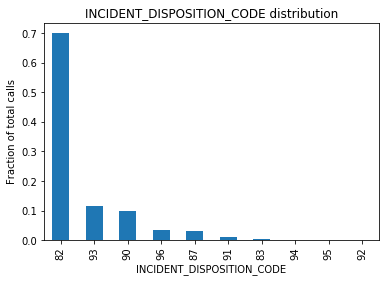

In [311]:
# Visualize INCIDENT_DISPOSITION_CODE distribution
df_concat['INCIDENT_DISPOSITION_CODE'].value_counts(normalize = True).plot.bar();
plt.xlabel('INCIDENT_DISPOSITION_CODE');
plt.ylabel('Fraction of total calls');
plt.title('INCIDENT_DISPOSITION_CODE distribution');

**Note:** Incident disposition codes--
* 82: Transporting patient (to hospital)
* 83: Patient pronounced dead
* 87: Call canceled
* 90: Call unfounded/no patient found
* 91: Condition corrected
* 92: Treated not transported
* 93: Refused medical attention
* 94: Treated & transferred care
* 95: Triaged at scene no transport
* 96: Patient gone upon arrival at scene

**Note:** The incident disposition codes of interest to us are 87 & 94: 87 refers to calls canceled, generally by other units, while 94 refers to calls where the unit provided some treatment on-scene, but the patient was transported by another unit.
* 87 = 3.26% of calls
* 94 = .09% of calls

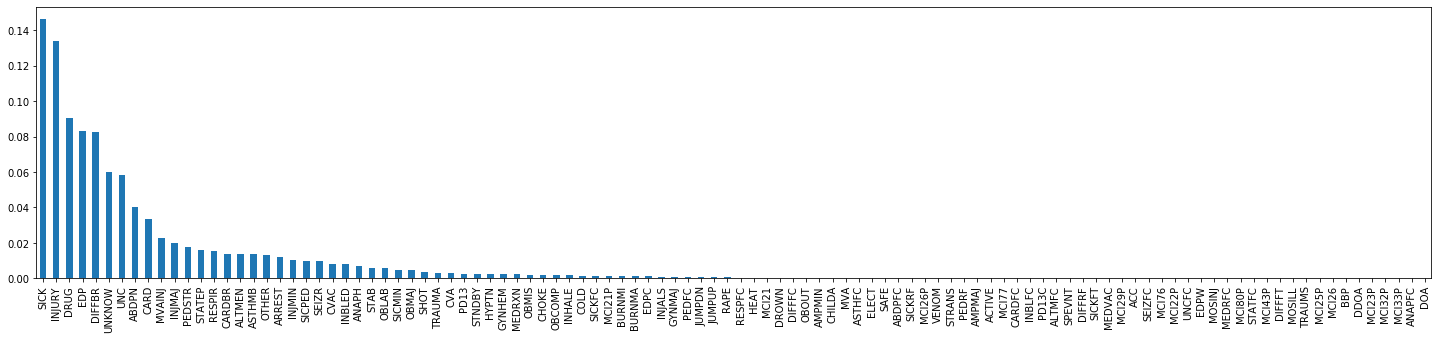

In [314]:
# Show INITIAL_CALL_TYPE distribution
df_concat['INITIAL_CALL_TYPE'].value_counts(normalize = True).plot.bar(figsize = (25, 5));

**Note:** There are over 100 possible call types that appear in this dataset, but their frequencies aren't evenly distributed--a handful of call types cover the vast majority of calls. Each call type is generally associated with 1 of 9 possible severity levels, with a level of 1 being most severe and 7 being least severe. 8 & 9 are infrequently used and usually refer specifically to the `STNDBY` calls, for which an ambulance is requested to stand-by in case it is needed, such as at the NY Marathon.

In [63]:
# Show INITIAL_SEVERITY_LEVEL_CODE distribution
df_concat['INITIAL_SEVERITY_LEVEL_CODE'].value_counts(normalize = True)

4    0.213413
2    0.205375
5    0.182053
6    0.159589
3    0.119604
7    0.103497
1    0.014074
8    0.002386
9    0.000009
Name: INITIAL_SEVERITY_LEVEL_CODE, dtype: float64

In [64]:
# 64937 total 87+94s in our dataset
df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]['FIRST_ON_SCENE_DATETIME'].shape

(64937,)

**Note:** 64_937 total canceled calls in our data (87 & 94 combined). However, of those, roughly 1/3 never make it to the scene. Those most likely refer to calls that were canceled en-route/by dispatch, because an extra unit was sent by mistake, because the location is bad, because the unit was no longer needed, or myriad other reasons. Of those 64_937 canceled calls, 43_520 make it as far as arriving on-scene.

In [65]:
# How many calls where a unit was actually dispatched and canceled on-scene rather than ahead of time?
df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]['FIRST_ON_SCENE_DATETIME'].notnull().sum()

43520

In [66]:
# Create new dataframe, just for canceled calls
df_canceled = df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]

In [67]:
# Isolating out all of the NOT null values for on-scene arrival, etc
df_canceled = df_canceled[df_canceled['FIRST_ON_SCENE_DATETIME'].notnull()]

In [68]:
df_canceled

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936650,130014763,2013-01-01 20:16:53,CARD,3,CARD,3,2013-01-01 20:17:06,Y,13,2013-01-01 20:17:13,2013-01-01 20:24:58,Y,485.0,472.0,NaT,NaT,2013-01-01 20:29:50,N,87,BROOKLYN,K1,11229
1936761,130014640,2013-01-01 19:44:19,INJURY,5,INJURY,5,2013-01-01 19:44:29,Y,10,2013-01-01 19:44:35,2013-01-01 19:47:59,Y,220.0,210.0,NaT,NaT,2013-01-01 19:56:53,N,87,MANHATTAN,M2,10003
1936791,130014606,2013-01-01 19:32:59,DIFFBR,2,DIFFBR,2,2013-01-01 19:33:14,Y,15,2013-01-01 19:33:26,2013-01-01 19:44:15,Y,676.0,661.0,NaT,NaT,2013-01-01 19:51:56,N,87,BROOKLYN,K1,11235
1936877,130014514,2013-01-01 19:02:26,ALTMEN,3,ALTMEN,3,2013-01-01 19:02:58,Y,32,2013-01-01 19:03:05,2013-01-01 19:11:16,Y,530.0,498.0,NaT,NaT,2013-01-01 19:17:42,N,94,QUEENS,Q2,11435


### Does the time spent on scene tell us anything useful?

In [295]:
# Create new variable CALL_LENGTH to represent the amount of time spent on-scene at a canceled call (in seconds)
df_canceled['CALL_LENGTH'] = (df_canceled['INCIDENT_CLOSE_DATETIME'] - df_canceled['FIRST_ON_SCENE_DATETIME']).astype('timedelta64[s]')

# Now convert this to minutes for a more intuitive number
df_canceled['CALL_LENGTH'] = round((df_canceled['CALL_LENGTH'] / 60), 2)

In [298]:
# How does it look?
df_canceled['CALL_LENGTH']

203        24.83
274        13.02
352        12.43
412        22.42
435         2.77
           ...  
1936650     4.87
1936761     8.90
1936791     7.68
1936877     6.43
1936886    22.48
Name: CALL_LENGTH, Length: 43520, dtype: float64

In [299]:
# Max and min call lengths (minutes)
print(f"Maximum call length = {np.max(df_canceled['CALL_LENGTH'])}")
print(f"Minimum call length = {np.min(df_canceled['CALL_LENGTH'])}")

Maximum call length = 347.98
Minimum call length = 0.0


**Note:** 
* 348 minutes = ~5.8 _hours_. A canceled call of that length can frequently be attributed to either a bug in the CAD system that wasn't corrected for, or some major incident with which the assigned unit was assisting, but did not actually end up transporting or even directly dealing with any patients themselves. (Multi-car pileups that end up having extra units at the scene just in case and/or because it's hard to tell how bad it is initially, etc.)
* 0 minutes frequently means that a unit is already on-scene when the assigned unit arrives, and if the scene appears to be under control, they may call it in as canceled and just keep driving. 

In [300]:
# How many calls result in over an hour spent at the scene before they are canceled?
df_canceled[df_canceled['CALL_LENGTH'] > 60]['INCIDENT_DISPOSITION_CODE'].value_counts()

87    543
94    122
Name: INCIDENT_DISPOSITION_CODE, dtype: int64

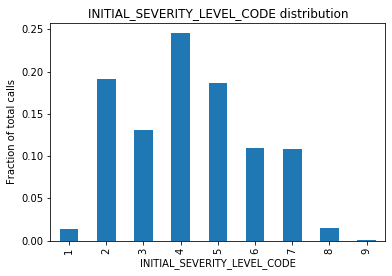

In [301]:
# What does the distribution of the severity levels look like, for canceled jobs?
df_canceled['INITIAL_SEVERITY_LEVEL_CODE'].value_counts(normalize = True).sort_index().plot.bar();
plt.xlabel('INITIAL_SEVERITY_LEVEL_CODE');
plt.ylabel('Fraction of total calls');
plt.title('INITIAL_SEVERITY_LEVEL_CODE distribution');

In [302]:
# Show the call type(s) that have a severity level of 8
df_canceled[df_canceled['INITIAL_SEVERITY_LEVEL_CODE'] == 8].head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,LOG_LENGTH
1206,183643988,2018-12-30 22:36:42,STNDBY,8,STNDBY,8,2018-12-30 22:38:24,Y,102,2018-12-30 22:39:36,2018-12-30 22:43:51,Y,429.0,327.0,NaT,NaT,2018-12-30 22:48:42,N,87,QUEENS,Q6,11105,4.85,1.568616
9038,183563547,2018-12-22 19:39:03,STNDBY,8,STNDBY,8,2018-12-22 19:39:03,Y,0,2018-12-22 19:39:03,2018-12-22 19:39:03,Y,0.0,0.0,NaT,NaT,2018-12-22 20:15:58,N,87,MANHATTAN,M2,10001,36.92,3.608212
10448,183544602,2018-12-20 22:52:11,STNDBY,8,STNDBY,8,2018-12-20 22:52:21,Y,10,2018-12-20 22:52:47,2018-12-20 22:56:16,Y,245.0,235.0,NaT,NaT,2018-12-20 23:14:41,N,87,BRONX,B3,10475,18.42,2.912351
11820,183533908,2018-12-19 20:43:09,STNDBY,8,STNDBY,8,2018-12-19 20:43:25,Y,16,2018-12-19 20:43:35,2018-12-19 20:51:14,Y,485.0,469.0,NaT,NaT,2018-12-19 23:56:51,N,87,RICHMOND / STATEN ISLAND,S1,10304,185.62,5.223594
14149,183503862,2018-12-16 22:39:55,STNDBY,8,MCI29,2,2018-12-16 22:40:04,Y,9,2018-12-16 22:40:47,2018-12-16 22:50:36,Y,641.0,632.0,NaT,NaT,2018-12-16 23:50:23,N,87,BRONX,B1,10451,59.78,4.091006


**Note:** Standby events removed from the dataset for purposes of the histograms because they aren't incidents where volunteer units would be picking up the calls as well. Also, a respectable number of the longer call lengths are associated with standby events--possibly because a CAD # might be assigned at the start of the event and not canceled 'til after it's over. Additionally, all call lengths over an hour were removed as well, under the assumption that for the most part, they're some form of operator error (bugs in the system), or assisting other units at an emergency scene (think car crash with multiple injured patients) and not officially getting "canceled" until they leave the scene.

In [303]:
# Remove stand-by events
df_canceled_ns = df_canceled[df_canceled['INITIAL_CALL_TYPE'] != 'STNDBY']

In [304]:
# Remove events with on-scene times over 1 hour
df_canceled_nl = df_canceled_ns[df_canceled_ns['CALL_LENGTH'] <= 60]

In [305]:
# How many calls have 0 time spent on-scene?
df_canceled_nl[df_canceled_nl['CALL_LENGTH'] == 0].shape

(3, 24)

In [306]:
# How many calls have > 60 mins spent on-scene?
df_canceled_ns[df_canceled_ns['CALL_LENGTH'] > 60].shape

(580, 24)

In [307]:
# Create a column in df_canceled_nl showing log-scale of call length
df_canceled['LOG_LENGTH'] = np.log(df_canceled['CALL_LENGTH'])

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Note:** For the log plot, ln(0) = $-\infty$, so zero-values need to be cut out for the data to plot properly.

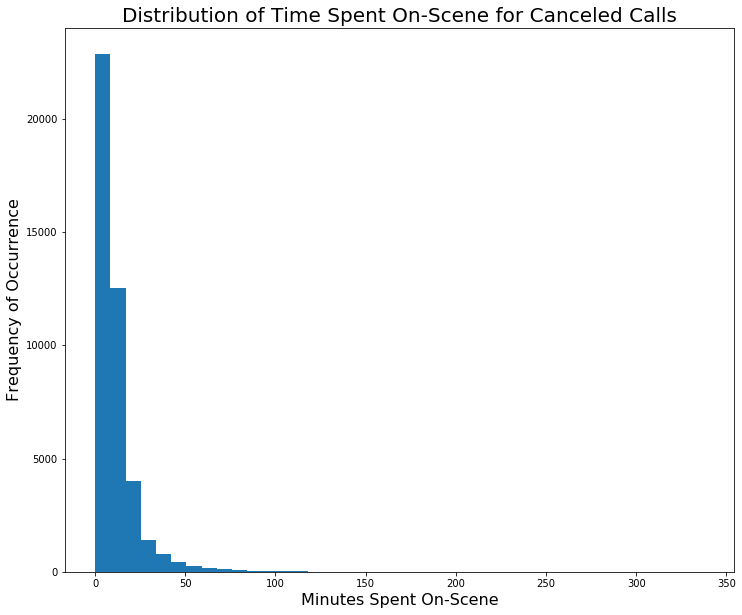

In [308]:
# Distribution of time spent on-scene for canceled calls
df_canceled_ns['CALL_LENGTH'].plot.hist(bins = 40, figsize = (12, 10));
plt.title('Distribution of Time Spent On-Scene for Canceled Calls', fontsize = 20);
plt.xlabel('Minutes Spent On-Scene', fontsize = 16);
plt.ylabel('Frequency of Occurrence', fontsize = 16);

**Note:** On-scene time is heavily skewed to the right, it's hard to determine anything from this plot because of the extreme tail.

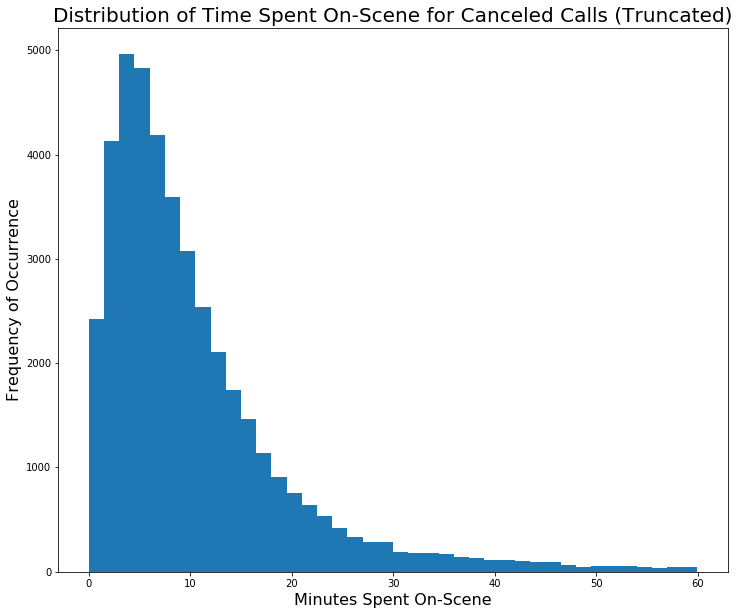

In [309]:
# Distribution of time spent on-scene for canceled calls
df_canceled_nl['CALL_LENGTH'].plot.hist(bins = 40, figsize = (12, 10));
plt.title('Distribution of Time Spent On-Scene for Canceled Calls (Truncated)', fontsize = 20);
plt.xlabel('Minutes Spent On-Scene', fontsize = 16);
plt.ylabel('Frequency of Occurrence', fontsize = 16);

**Note:** With the ~600 calls with on-scene time > 1 hour removed from our dataset, the severe skew is still apparently, but the drop-off appears much less steep.

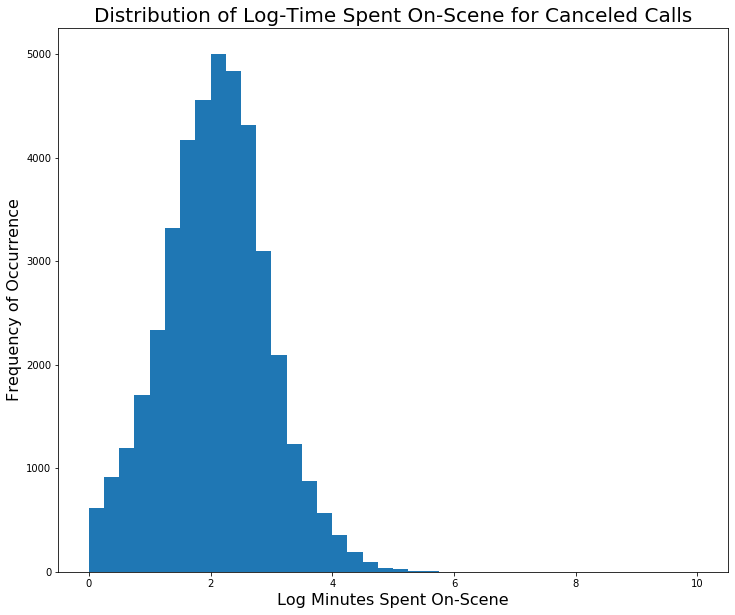

In [122]:
# Distribution of log-time spent on-scene for canceled calls
df_canceled_ns['LOG_LENGTH'].plot.hist(bins = 40, figsize = (12, 10), range = [0,10]);
plt.title('Distribution of Log-Time Spent On-Scene for Canceled Calls', fontsize = 20);
plt.xlabel('Log Minutes Spent On-Scene', fontsize = 16);
plt.ylabel('Frequency of Occurrence', fontsize = 16);

**Note:** Taking the log of the on-scene time provides a more normal-looking distribution. The hope was that we would see some sort of bimodal distribution, indicating potentially different causes for the canceled calls (such as the appearance of volunteer EMS vs too many units assigned by 911, etc). Unfortunately, there seems to be no evidence of that.

## Aggregate visualizations

**Note:** For ease of visualization, our data here are reduced to calls in Brooklyn _only_.

In [315]:
df_bk = df_canceled[df_canceled['BOROUGH'] == 'BROOKLYN']

In [316]:
# Only one CAD # occurred in the 11385 zipcode, which is located primarily in Queens. 
# This incident is being dropped because it skews everything else
df_bk = df_bk[df_bk['ZIPCODE'] != 11385]

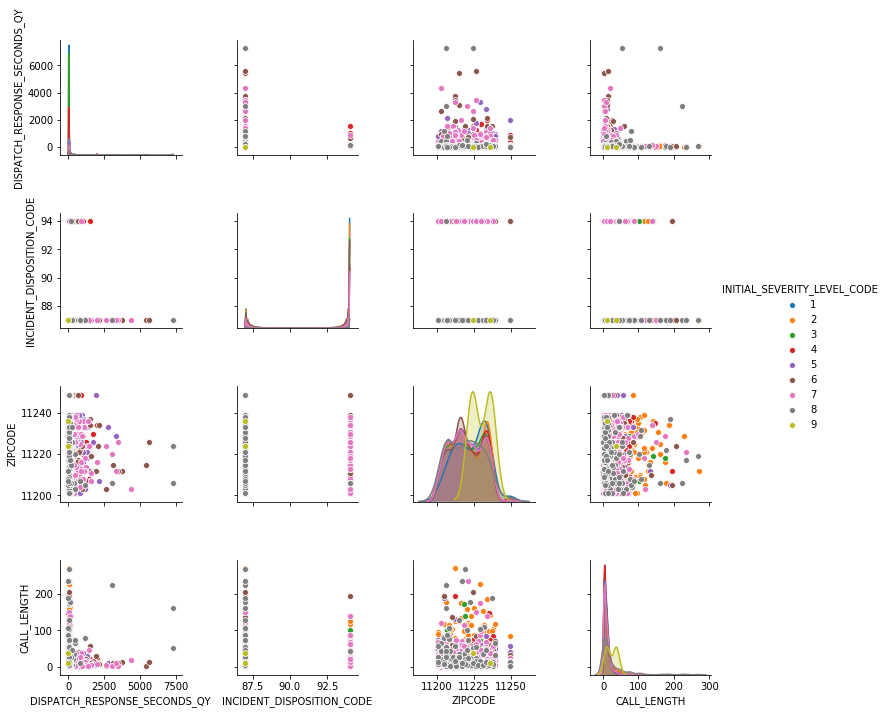

In [318]:
sns.pairplot(data = df_bk,
             vars = ['DISPATCH_RESPONSE_SECONDS_QY','INCIDENT_DISPOSITION_CODE', 'ZIPCODE', 'CALL_LENGTH'],
             hue = 'INITIAL_SEVERITY_LEVEL_CODE');

**Note:** No obvious relationships between numeric variables pop up here.

In [367]:
df_bk.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,781.0
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,746.0
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,166.0


### Canceled calls

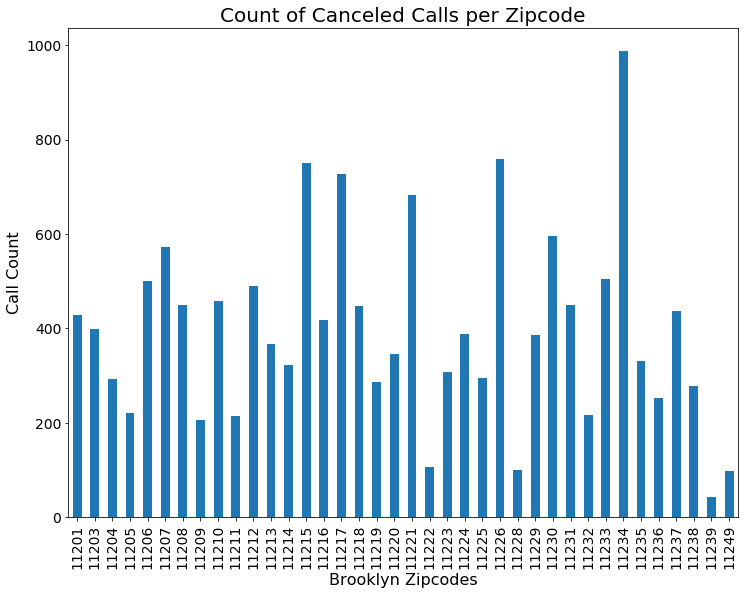

In [144]:
fig, ax = plt.subplots(figsize=(12,9))
df_bk.groupby('ZIPCODE')['CAD_INCIDENT_ID'].count().plot.bar(ax = ax);
ax.set_title('Count of Canceled Calls per Zipcode', fontsize = 20);
ax.set_xlabel('Brooklyn Zipcodes', fontsize = 16);
ax.set_ylabel('Call Count', fontsize = 16)
ax.tick_params(labelsize = 14)

**Notes:** <br>

High numbers of canceled calls: <br>
* 11234: Flatlands, contains the Flatlands VAC
* 11215/11217: Park Slope & Prospect Heights, both within the Park Slope VAC radius
* 11226: Flatbush, contains East Midwood VAC, as well as significant presence of Hatzolah
* 11221: Bedford-Stuyvesant, contains the Bedford Stuyvesant VAC

Low numbers of canceled calls: <br>
* 11222: Greenpoint, no significant VAC activity of any kind in evidence.
* 11239: East New York/Starrett City, no significant VAC activity but also relatively low population
* 11249: Western Williamsburg

### Severity level codes

Is there anything interesting to see about the relative proportions of different severity levels throughout Brooklyn zipcodes?

In [320]:
# Get normalized distribution of INITIAL_SEVERITY_LEVEL_CODE values
df_bk_severity = ((df_bk.groupby(['ZIPCODE', 'INITIAL_SEVERITY_LEVEL_CODE']).count())/(df_bk.groupby(['ZIPCODE']).count()).drop(columns = 'INITIAL_SEVERITY_LEVEL_CODE')).reset_index()

In [321]:
df_bk_severity

,ZIPCODE,INITIAL_SEVERITY_LEVEL_CODE,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,CALL_LENGTH,LOG_LENGTH
0,11201,1,0.011682,0.011682,0.011682,0.011682,0.011682,0.011682,0.011682,0.011682,0.011710,0.011682,0.011682,0.011682,0.011682,0.0,NaN,0.011682,0.011682,0.011682,0.011682,0.011682,0.011682,0.011682
1,11201,2,0.158879,0.158879,0.158879,0.158879,0.158879,0.158879,0.158879,0.158879,0.159251,0.158879,0.158879,0.158879,0.158879,0.0,NaN,0.158879,0.158879,0.158879,0.158879,0.158879,0.158879,0.158879
2,11201,3,0.098131,0.098131,0.098131,0.098131,0.098131,0.098131,0.098131,0.098131,0.098361,0.098131,0.098131,0.098131,0.098131,0.0,NaN,0.098131,0.098131,0.098131,0.098131,0.098131,0.098131,0.098131
3,11201,4,0.245327,0.245327,0.245327,0.245327,0.245327,0.245327,0.245327,0.245327,0.245902,0.245327,0.245327,0.245327,0.245327,0.0,NaN,0.245327,0.245327,0.245327,0.245327,0.245327,0.245327,0.245327
4,11201,5,0.198598,0.198598,0.198598,0.198598,0.198598,0.198598,0.198598,0.198598,0.199063,0.198598,0.198598,0.198598,0.198598,0.5,NaN,0.198598,0.198598,0.198598,0.198598,0.198598,0.198598,0.198598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,11249,4,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.0,0.0,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636
299,11249,5,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,1.0,1.0,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
300,11249,6,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.0,0.0,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606,0.060606
301,11249,7,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.0,0.0,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707,0.070707


In [322]:
# Try this with a pivot table
df_bk_severity_pivot = df_bk_severity.pivot(index = 'ZIPCODE', columns = 'INITIAL_SEVERITY_LEVEL_CODE', values = 'CAD_INCIDENT_ID')

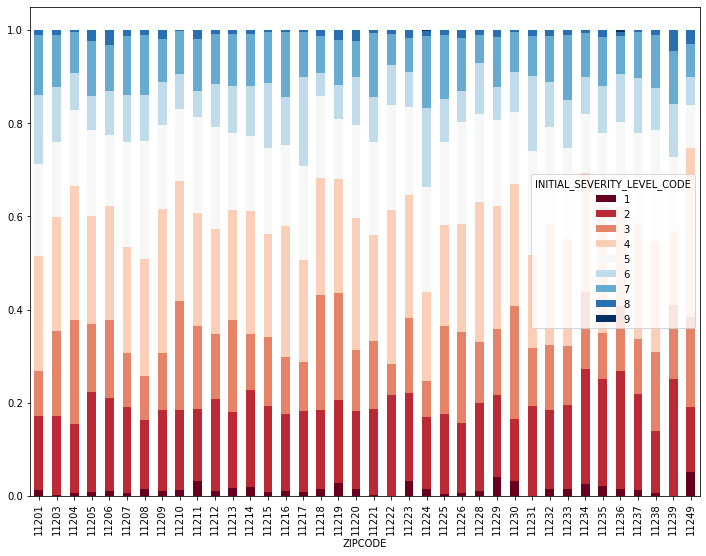

In [88]:
# Pivot table visualization
df_bk_severity_pivot.plot.bar(stacked=True, figsize=(12,9), cmap = 'RdBu');

**Note:** A severity level of 1 indicates a potentially critical patient, while a severity level of 7 indicates a relatively low-priority call. High absolute numbers of canceled calls don't appear to relate significantly to call priority--11234, for instance, has a higher proportion of severe calls (codes 1-3), while 11215 and 11217 have lower proportions of severe calls. Call severity may well also have more to do with population demographics than anything else--certain neighborhoods will have higher numbers of the very old or the very young, with accompanying respiratory vulnerability, etc.

## Mapping dispatch activity by zipcode

### Building a mappable dataframe

#### Import zipcodes shapefile

In [152]:
# Make sure to map the polygons to a coordinate reference system
gdf = gpd.read_file('../data/zipcodes/ZIP_CODE_040114.shp').to_crs(epsg=4326)

In [40]:
# What do our zipcodes look like?
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [154]:
gdf.dtypes

ZIPCODE          int64
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [153]:
# Set gdf zipcode column to same datatype as df_concat zipcode column
gdf['ZIPCODE'] = gdf['ZIPCODE'].astype('int64')

In [155]:
# remove the one fully duplicate row...though this doesn't deal with the other partial duplicates
gdf.drop_duplicates(inplace = True)

In [156]:
# Find indices of rows with duplicate zipcodes
dupzips_gdf = gdf.loc[gdf.duplicated(subset = 'ZIPCODE')].index

**Note:** A number of rows are partial duplicates--they contain duplicate zipcodes, with different areas and different polygon boundaries. Sometimes these differences are slight, sometimes they are more extreme. In our case, however, polygon boundaries are only for mapping purposes, not for calculating anything qualitatively--the only _values_ we need from the shapefile are zipcode and population, which are consistent across the duplicates. Additionally, it seemed impossible to independently verify _which_ zipcode area was the correct one--numbers available through Google did not match any of the values in our dataset.

In [159]:
# Drop partial duplicates
gdf.drop(index = dupzips_gdf, inplace = True)

#### Zipcodes in dispatch df & NOT in zipcodes df

In [323]:
# How many zipcodes in dispatch dataset?
set_zip_df = set(list(df_concat['ZIPCODE'].values))

In [324]:
len(set_zip_df)

227

In [325]:
# How many zipcodes in zipcodes gdf?
set_zip_gdf = set(list(gdf['ZIPCODE'].values))

In [326]:
len(set_zip_gdf)

248

In [331]:
# Find indices of rows with anomalous zipcodes
badzip_ind = df_concat.loc[df_concat.ZIPCODE.isin(list(set_zip_df - set_zip_gdf))].index

In [332]:
badzip_ind

Int64Index([], dtype='int64')

**Note:** No zipcodes in df that aren't in the zipcodes df, which is helpful/means less manipulation is necessary

#### Zipcodes in zipcodes df & NOT in dispatch df

In [335]:
# These zipcodes will be eliminated when this df is joined to the dispatch df on the zip column
len(set_zip_gdf - set_zip_df)

21

In [343]:
# Save list of zipcodes in gdf and not df
zips_unshared = list(set_zip_gdf - set_zip_df)

In [344]:
# Show list of zipcodes
zips_unshared

[10259,
 10260,
 10265,
 10270,
 10275,
 10285,
 10286,
 10166,
 10043,
 11451,
 10047,
 10175,
 10196,
 11096,
 10203,
 10080,
 10081,
 11371,
 10096,
 10097,
 10104]

In [345]:
# Show rows with zipcodes not found in the dispatch dataset
gdf[gdf.ZIPCODE.isin(zips_unshared)]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
139,11096,0,Inwood,147.0,1.512446e+06,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.76740 40.61546, -73.76763 40.615..."
178,11451,0,Jamaica,0.0,4.875997e+05,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80157 40.70121, -73.80131 40.701..."
214,10166,1,New York,0.0,1.104386e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97728 40.75351, -73.97728 40.753..."
220,10270,1,New York,0.0,3.125580e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00822 40.70654, -74.00794 40.706..."
221,10104,1,New York,0.0,8.972185e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97826 40.76005, -73.97835 40.759..."
224,10175,1,New York,0.0,1.868539e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98000 40.75441, -73.97965 40.754..."
236,10043,1,New York,0.0,3.826236e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00708 40.70387, -74.00750 40.704..."
237,10081,1,New York,0.0,3.024051e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00871 40.70749, -74.00949 40.707..."
238,10096,1,New York,0.0,4.210611e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98302 40.75485, -73.98283 40.755..."
239,10097,1,New York,0.0,6.582618e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98522 40.76265, -73.98483 40.762..."


#### Join the two dataframes

In [188]:
# To get the distribution of INCIDENT_DISTRIBUTION_CODE per zipcode
(df_concat.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count())

CAD_INCIDENT_ID  INCIDENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                       
83      82                                       2                  2   
        87                                       1                  1   
        90                                       1                  1   
10001   82                                   15100              15100   
        83                                      30                 30   
...                                            ...                ...   
11697   90                                      37                 37   
        91                                       8                  8   
        93                                      35                 35   
        94                                       9                  9   
        96                                      15                 15   

                                   INITIAL_CALL_TYPE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                      
83      82                                         2   
        87                                         1   
        90                                         1   
10001   82                                     15100   
        83                                        30   
...                                              ...   
11697   90                                        37   
        91                                         8   
        93                                        35   
        94                                         9   
        96                                        15   

                                   INITIAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                
83      82                                                   2   
        87                                                   1   
        90                                                   1   
10001   82                                               15100   
        83                                                  30   
...                                                        ...   
11697   90                                                  37   
        91                                                   8   
        93                                                  35   
        94                                                   9   
        96                                                  15   

                                   FINAL_CALL_TYPE  FINAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                               
83      82                                       2                          2   
        87                                       1                          1   
        90                                       1                          1   
10001   82                                   15100                      15100   
        83                                      30                         30   
...                                            ...                        ...   
11697   90                                      37                         37   
        91                                       8                          8   
        93                                      35                         35   
        94                                       9                          9   
        96                                      15                         15   

                                   FIRST_ASSIGNMENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                              
83      82                                                 2   
        87                                                 1   
        90                                                 1   
10001   82                                             15100   
        83                                                3

In [346]:
# And now, normalized INCIDENT_DISPOSITION_CODE distribution per zip
df_normzipdisp = ((df_concat.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count())/(df_concat.groupby(['ZIPCODE']).count())).drop(columns = 'INCIDENT_DISPOSITION_CODE').reset_index()

In [347]:
df_normzipdisp

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC
0,83,82,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,83,87,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
2,83,90,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
3,10001,82,0.636701,0.636701,0.636701,0.636701,0.636701,0.637562,0.636701,0.9978,0.646312,0.995967,0.636701,0.636655,0.636701,0.636701,0.646312,0.646312,0.636701,0.636701,0.636701,0.636701
4,10001,83,0.001265,0.001265,0.001265,0.001265,0.001265,0.001268,0.001265,0.0000,0.001305,0.000000,0.001265,0.001265,0.001265,0.001265,0.001305,0.001305,0.001265,0.001265,0.001265,0.001265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,11697,90,0.103933,0.103933,0.103933,0.103933,0.103933,0.103933,0.103933,0.0000,0.111455,0.000000,0.103933,0.103933,0.103933,0.103933,0.111455,0.111455,0.103933,0.103933,0.103933,0.103933
1664,11697,91,0.022472,0.022472,0.022472,0.022472,0.022472,0.022472,0.022472,0.0000,0.024768,0.000000,0.022472,0.022472,0.022472,0.022472,0.024768,0.024768,0.022472,0.022472,0.022472,0.022472
1665,11697,93,0.098315,0.098315,0.098315,0.098315,0.098315,0.098315,0.098315,0.0000,0.108359,0.000000,0.098315,0.098315,0.098315,0.098315,0.108359,0.108359,0.098315,0.098315,0.098315,0.098315
1666,11697,94,0.025281,0.025281,0.025281,0.025281,0.025281,0.025281,0.025281,0.0000,0.027864,0.000000,0.025281,0.025281,0.025281,0.025281,0.027864,0.027864,0.025281,0.025281,0.025281,0.025281


In [194]:
# Aaaaand merge the dataframes, at long last!
merged_df = pd.merge(df_normzipdisp, gdf, how = 'left', on = 'ZIPCODE')

**Note:** Any time data needs to be mapped, make sure the data is in the exact shape/format it needs for plotting _before_ it is merged with the geometry data. Otherwise any aggregation techniques used will be applied to the geometry as well, which will kill its ability to create lovely maps.

#### Create GeoPandas Dataframe

In [196]:
# Create GeoPandas DataFrame from merged df and its associated geometry column
gdf_geo = gpd.GeoDataFrame(merged_df, geometry = merged_df.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

**Note:** If just plotting canceled calls, we want to look at the combination of 87 and 94 calls only, we don't care about the rest. Their individual, normalized contributions to the dataset are all in merged_df and gdf_geo, so now we isolate and combine those values.

In [348]:
gdf_geo_87 = gdf_geo[gdf_geo['INCIDENT_DISPOSITION_CODE'] == 87]
gdf_geo_94 = gdf_geo[gdf_geo['INCIDENT_DISPOSITION_CODE'] == 94]
gdf_canceled_merged = pd.merge(gdf_geo_87, gdf_geo_94, how = 'outer', on = 'ZIPCODE', suffixes=('_87', '_94'))

In [352]:
gdf_canceled_merged.shape

(206, 67)

In [220]:
gdf_canceled_merged['geometry_87'].notnull().sum()

206

In [222]:
gdf_canceled_merged['ZIPCODE'].notnull().sum()

206

**Note:** While not all zipcodes contain both 87 and 94 calls, especially the ones with low call volume overall, all zipcodes _do_ seem to contain 87 calls, so that's a column that can be used as a reference and the 94 values just added to it where they exist at all.

In [353]:
# Convert NaNs to 0
gdf_canceled_merged['BOROUGH_94'].fillna(0, inplace = True)

**Note:** Where a zipcode does _not_ have any 94 calls, the merge fills those cells with NaN values instead, so we replace the NaNs with 0 so that the columns can be safely added together without issue or error.

In [354]:
# Create a new, empty GeoDataFrame
gdf_canceled = gpd.GeoDataFrame()

In [355]:
# Fill this GeoDataFrame with only the columns that we actually need
gdf_canceled['ZIPCODE'] = gdf_canceled_merged['ZIPCODE']
gdf_canceled['CANCELED_PROP'] = gdf_canceled_merged['BOROUGH_87'] + gdf_canceled_merged['BOROUGH_94']
gdf_canceled['POPULATION'] = gdf_canceled_merged['POPULATION_87']
gdf_canceled['geometry'] = gdf_canceled_merged['geometry_87']

In [356]:
# How does it look?
gdf_canceled.head()

,ZIPCODE,CANCELED_PROP,POPULATION,geometry
0,83,0.250000,25.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
1,10001,0.044611,22413.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
2,10002,0.027891,81305.0,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
3,10003,0.035537,55878.0,"POLYGON ((-73.97986 40.73497, -73.98028 40.734..."
4,10004,0.042349,2187.0,"POLYGON ((-74.01101 40.70622, -74.00997 40.705..."


### How is the canceled call ratio distributed across the city?

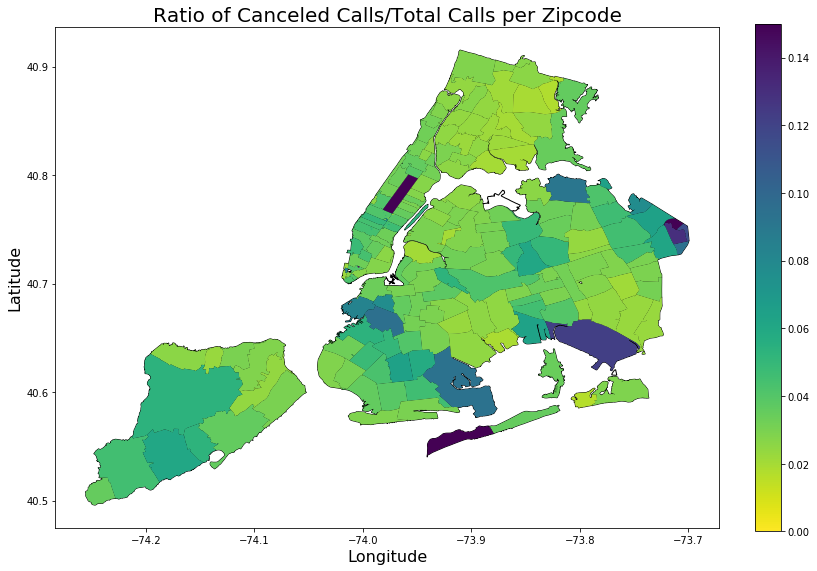

In [267]:
# Plot ratio of canceled calls per zip
fig, ax = plt.subplots(figsize = (13, 13))
gdf.plot(ax=ax, color='white', edgecolor='black')
gdf_canceled.plot('CANCELED_PROP', legend=True, ax=ax,  # All df columns are identical
             cmap='viridis_r', legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0,
             vmax = 0.15)
ax.set_title('Ratio of Canceled Calls/Total Calls per Zipcode', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

### What about overall call frequency per capita?

In [268]:
# To get the distribution of INCIDENT_DISTRIBUTION_CODE per zipcode
df_zipcalls = (df_concat.groupby(['ZIPCODE']).count())

In [269]:
# merge with zipcodes df
df_zipcalls_geo = pd.merge(df_zipcalls, gdf, how = 'left', on = 'ZIPCODE')

In [270]:
# Create GeoDataFrame for mapping
gdf_zipcalls = gpd.GeoDataFrame(df_zipcalls_geo, geometry = df_zipcalls_geo.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

In [271]:
gdf_zipcalls.head()

,ZIPCODE,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,83,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,4,4,4,4,4,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
1,10001,23716,23716,23716,23716,23716,23716,23716,23716,23716,23662,22992,23716,22992,22992,15124,15003,23713,23716,23716,23716,23716,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
2,10002,23162,23162,23162,23162,23162,23162,23162,23162,23162,23119,22585,23162,22585,22585,15737,15655,23162,23162,23162,23162,23162,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
3,10003,21752,21752,21752,21752,21752,21752,21752,21752,21752,21694,21166,21752,21166,21166,13345,13269,21749,21752,21752,21752,21752,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97986 40.73497, -73.98028 40.734..."
4,10004,2503,2503,2503,2503,2503,2503,2503,2503,2503,2496,2422,2503,2422,2422,1677,1671,2503,2503,2503,2503,2503,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.01101 40.70622, -74.00997 40.705..."


**Note:** Certain zipcodes have populations of 0--think of areas in Manhattan with no residential zoning. EMS will be called to those locations to treat patients, but those incidents won't be factored into a calculation of calls per capita. Out of 227 zipcodes in NYC, 41 have POPULATION = 0.

In [278]:
gdf_zippop = gdf_zipcalls[gdf_zipcalls['POPULATION'] != 0]

In [279]:
gdf_zippop['PERCAP'] = gdf_zippop['CAD_INCIDENT_ID'] / gdf_zippop['POPULATION']

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [281]:
gdf_zippop[gdf_zippop['PERCAP'] > 100]

,ZIPCODE,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,PERCAP
216,11430,5143,5143,5143,5143,5143,5143,5143,5143,5143,5138,4952,5143,4952,4952,3464,3437,5142,5143,5143,5143,5143,0,Jamaica,16.0,1.999137e+08,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.78941 40.66684, -73.78944 40.666...",321.4375


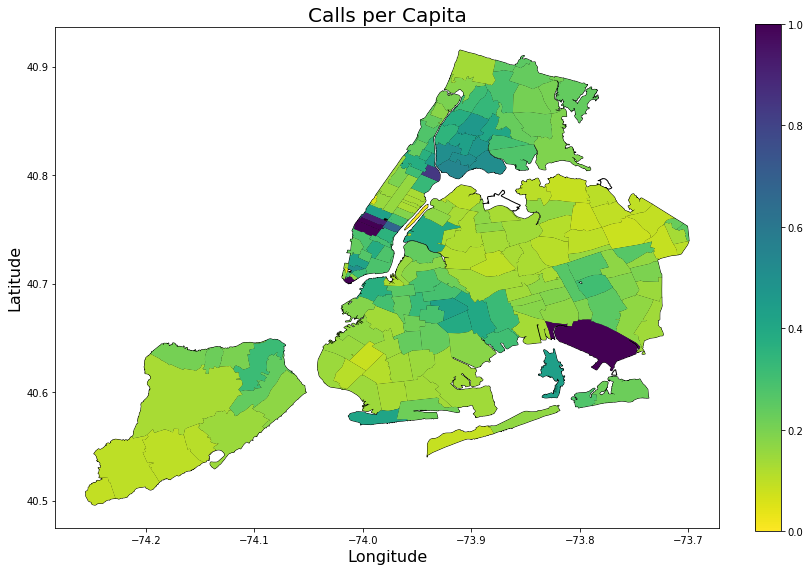

In [286]:
# Plot ratio of canceled calls per zip
fig, ax = plt.subplots(figsize = (13, 13))
gdf.plot(ax=ax, color='white', edgecolor='black')
gdf_zippop.plot('PERCAP', legend=True, ax=ax,  # All df columns are identical
             cmap='viridis_r', legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0, vmax = 1)
ax.set_title('Calls per Capita', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

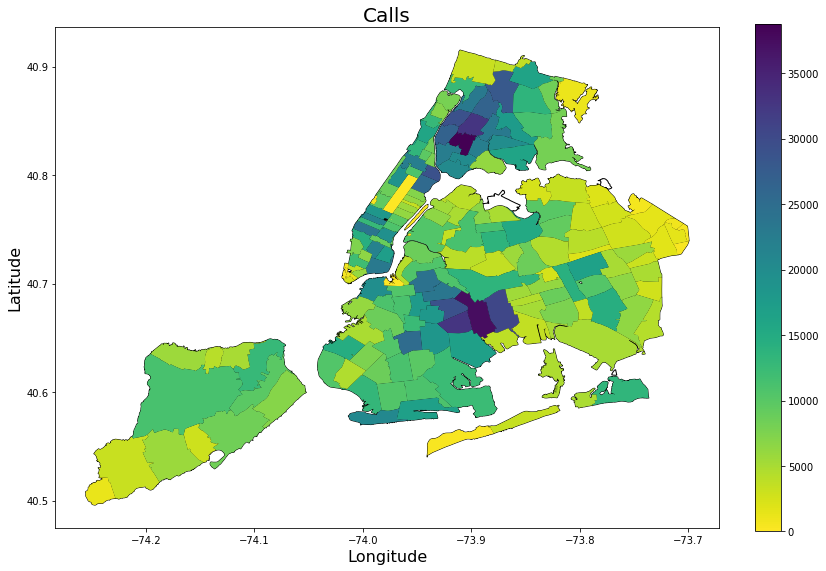

In [288]:
# Plot ratio of canceled calls per zip
fig, ax = plt.subplots(figsize = (13, 13))
gdf.plot(ax=ax, color='white', edgecolor='black')
gdf_zippop.plot('CAD_INCIDENT_ID', legend=True, ax=ax,  # All df columns are identical
             cmap='viridis_r', legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0)
ax.set_title('Calls', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

## K-Modes Clustering...

In [562]:
# Thanks to https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas

# Binning CALL_LENGTH turns it into a categorical variable, and therefore usable in k-modes
bins = [0, 5, 7.5, 10, 12.5, 15, 22.5, 30, 60, 360]
df_canceled['CALL_LENGTH_BINNED'] = pd.cut(df_canceled['CALL_LENGTH'], bins)

In [359]:
df_canceled['CALL_LENGTH_BINNED'].value_counts()

(0.0, 5.0]       13413
(5.0, 7.5]        7372
(7.5, 10.0]       5717
(15.0, 22.5]      4958
(10.0, 12.5]      4325
(12.5, 15.0]      3102
(30.0, 60.0]      2079
(22.5, 30.0]      1879
(60.0, 360.0]      665
Name: CALL_LENGTH_BINNED, dtype: int64

In [360]:
df_canceled.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,LOG_LENGTH,CALL_LENGTH_BINNED
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,24.83,3.212053,"(22.5, 30.0]"
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,13.02,2.566487,"(12.5, 15.0]"
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,12.43,2.520113,"(10.0, 12.5]"
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,22.42,3.109953,"(15.0, 22.5]"
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,2.77,1.018847,"(0.0, 5.0]"


In [361]:
df_canceled['ZIPCODE'].value_counts()

11234    987
11226    758
11215    751
11217    727
10001    706
        ... 
10278      1
10103      1
10129      1
10045      1
10107      1
Name: ZIPCODE, Length: 203, dtype: int64

In [362]:
df_canceled

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,LOG_LENGTH,CALL_LENGTH_BINNED
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,24.83,3.212053,"(22.5, 30.0]"
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,13.02,2.566487,"(12.5, 15.0]"
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,12.43,2.520113,"(10.0, 12.5]"
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,22.42,3.109953,"(15.0, 22.5]"
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,2.77,1.018847,"(0.0, 5.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936650,130014763,2013-01-01 20:16:53,CARD,3,CARD,3,2013-01-01 20:17:06,Y,13,2013-01-01 20:17:13,2013-01-01 20:24:58,Y,485.0,472.0,NaT,NaT,2013-01-01 20:29:50,N,87,BROOKLYN,K1,11229,4.87,1.583094,"(0.0, 5.0]"
1936761,130014640,2013-01-01 19:44:19,INJURY,5,INJURY,5,2013-01-01 19:44:29,Y,10,2013-01-01 19:44:35,2013-01-01 19:47:59,Y,220.0,210.0,NaT,NaT,2013-01-01 19:56:53,N,87,MANHATTAN,M2,10003,8.90,2.186051,"(7.5, 10.0]"
1936791,130014606,2013-01-01 19:32:59,DIFFBR,2,DIFFBR,2,2013-01-01 19:33:14,Y,15,2013-01-01 19:33:26,2013-01-01 19:44:15,Y,676.0,661.0,NaT,NaT,2013-01-01 19:51:56,N,87,BROOKLYN,K1,11235,7.68,2.038620,"(7.5, 10.0]"
1936877,130014514,2013-01-01 19:02:26,ALTMEN,3,ALTMEN,3,2013-01-01 19:02:58,Y,32,2013-01-01 19:03:05,2013-01-01 19:11:16,Y,530.0,498.0,NaT,NaT,2013-01-01 19:17:42,N,94,QUEENS,Q2,11435,6.43,1.860975,"(5.0, 7.5]"


In [363]:
# Get rid of all numeric/non-categorical columns
df_canceled_nonum = df_canceled.drop(columns = ['INCIDENT_DATETIME',
                                             'FINAL_CALL_TYPE',
                                             'INITIAL_SEVERITY_LEVEL_CODE',
                                             'FINAL_SEVERITY_LEVEL_CODE',
                                             'INCIDENT_DISPOSITION_CODE',
                                             'FIRST_ASSIGNMENT_DATETIME',
                                             'DISPATCH_RESPONSE_SECONDS_QY',
                                             'FIRST_ACTIVATION_DATETIME',
                                             'FIRST_ON_SCENE_DATETIME',
                                             'FIRST_TO_HOSP_DATETIME',
                                             'FIRST_HOSP_ARRIVAL_DATETIME',
                                             'INCIDENT_CLOSE_DATETIME',
                                             'HELD_INDICATOR',
                                             'INCIDENT_TRAVEL_TM_SECONDS_QY',
                                             'INCIDENT_RESPONSE_SECONDS_QY',
                                             'VALID_INCIDENT_RSPNS_TIME_INDC',
                                             'VALID_DISPATCH_RSPNS_TIME_INDC',
                                             'CALL_LENGTH',
                                             'LOG_LENGTH'])

In [364]:
df_canceled_nonum.shape

(43520, 6)

In [365]:
# Set CAD_INCIDENT_ID as the index for this df
df_canceled_nonum.set_index('CAD_INCIDENT_ID', inplace = True)

In [366]:
df_canceled_nonum.shape

(43520, 5)

In [367]:
# Pull out events in Brooklyn only
df_canceled_bk = df_canceled_nonum[df_canceled_nonum['BOROUGH'] == 'BROOKLYN']

In [373]:
df_canceled_bk['INITIAL_CALL_TYPE'].value_counts()[:25]

INJURY    2501
EDP       1310
SICK      1292
UNKNOW    1172
PEDSTR    1143
DRUG      1062
MVAINJ    1012
UNC        903
DIFFBR     685
INJMAJ     288
CARD       279
ABDPN      263
MCI21P     256
OTHER      250
STATEP     235
TRAUMA     199
RESPIR     199
ARREST     186
SHOT       156
ASTHMB     151
STNDBY     151
SEIZR      150
INJMIN     137
STAB       113
PD13       112
Name: INITIAL_CALL_TYPE, dtype: int64

### Dummy categorical variables

In [370]:
df_canceled_bk['INCIDENT_DISPATCH_AREA'].value_counts()

K4    2932
K6    2688
K2    2454
K1    2174
K7    2092
K3    1469
K5    1256
M3      10
M1       7
Q4       6
M5       4
M2       4
Q1       3
Q3       3
Q2       2
Q6       2
S1       1
Q7       1
M7       1
M6       1
M4       1
X1       1
Name: INCIDENT_DISPATCH_AREA, dtype: int64

In [371]:
X = pd.get_dummies(df_canceled_bk, columns = ['INITIAL_CALL_TYPE',
                                                'BOROUGH',
                                                'INCIDENT_DISPATCH_AREA', 'ZIPCODE',
                                                'CALL_LENGTH_BINNED'], drop_first = True)

In [374]:
X.shape

(15112, 140)

In [375]:
X.head()

,INITIAL_CALL_TYPE_ACC,INITIAL_CALL_TYPE_ALTMEN,INITIAL_CALL_TYPE_AMPMIN,INITIAL_CALL_TYPE_ANAPH,INITIAL_CALL_TYPE_ARREST,INITIAL_CALL_TYPE_ASTHFC,INITIAL_CALL_TYPE_ASTHMB,INITIAL_CALL_TYPE_BURNMA,INITIAL_CALL_TYPE_BURNMI,INITIAL_CALL_TYPE_CARD,INITIAL_CALL_TYPE_CARDBR,INITIAL_CALL_TYPE_CHILDA,INITIAL_CALL_TYPE_CHOKE,INITIAL_CALL_TYPE_COLD,INITIAL_CALL_TYPE_CVA,INITIAL_CALL_TYPE_CVAC,INITIAL_CALL_TYPE_DIFFBR,...,ZIPCODE_11233,ZIPCODE_11234,ZIPCODE_11235,ZIPCODE_11236,ZIPCODE_11237,ZIPCODE_11238,ZIPCODE_11239,ZIPCODE_11249,ZIPCODE_11385,"CALL_LENGTH_BINNED_(5.0, 7.5]","CALL_LENGTH_BINNED_(7.5, 10.0]","CALL_LENGTH_BINNED_(10.0, 12.5]","CALL_LENGTH_BINNED_(12.5, 15.0]","CALL_LENGTH_BINNED_(15.0, 22.5]","CALL_LENGTH_BINNED_(22.5, 30.0]","CALL_LENGTH_BINNED_(30.0, 60.0]","CALL_LENGTH_BINNED_(60.0, 360.0]"
CAD_INCIDENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
183654152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
183654073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
183653977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
183653901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
183653875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Initiate k-modes

#### n_clusters = 3

In [550]:
# Credit to https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae
# and https://pypi.org/project/kmodes/

# define the k-modes model
km = KModes(n_clusters=3, init='Huang', n_init=11, verbose=1)

# fit the clusters to the skills dataframe
clusters = km.fit_predict(X)
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape
# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.
# If no "1" appears, assign to "no-features" cluster.
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-features cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in X.columns[np.nonzero(cent)]:
            print(j)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2660, cost: 49119.0
Run 1, iteration: 2/100, moves: 164, cost: 49119.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8893, cost: 50121.0
Run 2, iteration: 2/100, moves: 5, cost: 50121.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1349, cost: 49552.0
Run 3, iteration: 2/100, moves: 0, cost: 49552.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3354, cost: 48314.0
Run 4, iteration: 2/100, moves: 0, cost: 48314.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1702, cost: 49355.0
Run 5, iteration: 2/100, moves: 0, cost: 49355.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iterat

In [551]:
# Create new column in the Brooklyn dataframe
df_canceled_bk['CLUSTER3'] = km.labels_

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [552]:
df_canceled_bk

,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH_BINNED,CLUSTER,CLUSTER3,CLUSTER12
CAD_INCIDENT_ID,,,,,,,,
183654152,RESPIR,BROOKLYN,K7,11221,"(22.5, 30.0]",1,1,9
183654073,UNC,BROOKLYN,K4,11236,"(12.5, 15.0]",0,0,0
183653977,UNKNOW,BROOKLYN,K1,11210,"(10.0, 12.5]",1,1,0
183653901,PEDSTR,BROOKLYN,K4,11236,"(15.0, 22.5]",0,0,1
183653875,UNKNOW,BROOKLYN,K6,11231,"(0.0, 5.0]",1,1,8
...,...,...,...,...,...,...,...,...
130023191,DRUG,BROOKLYN,K7,11207,"(10.0, 12.5]",1,1,9
130015308,CARD,BROOKLYN,K4,11234,"(0.0, 5.0]",0,0,0
130015132,STATEP,BROOKLYN,K2,11226,"(7.5, 10.0]",1,2,4


In [553]:
len(set(df_canceled_bk['ZIPCODE']))

39

In [554]:
bk_cluster_agg = df_canceled_bk.groupby(['ZIPCODE','CLUSTER3']).count().reset_index()

In [555]:
bk_cluster_agg.head(6)

,ZIPCODE,CLUSTER3,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,CALL_LENGTH_BINNED,CLUSTER,CLUSTER12
0,11201,0,2,2,2,2,2,2
1,11201,1,424,424,424,424,424,424
2,11201,2,2,2,2,2,2,2
3,11203,0,18,18,18,18,18,18
4,11203,1,377,377,377,377,377,377
5,11203,2,3,3,3,3,3,3


In [556]:
# With assistance from Noah C

list_cluster = []
list_zip = []
for zipcode in set(bk_cluster_agg['ZIPCODE']):
    zip_max_calls = np.max(bk_cluster_agg[bk_cluster_agg['ZIPCODE'] == zipcode]['INITIAL_CALL_TYPE'])
    max_cluster =  bk_cluster_agg[(bk_cluster_agg['ZIPCODE']==zipcode) & (bk_cluster_agg['INITIAL_CALL_TYPE'] == zip_max_calls)]['CLUSTER3'].values[0]
    list_cluster.append(max_cluster)
    list_zip.append(zipcode)
    
df_cluster3 = pd.DataFrame({
    'ZIPCODE' : list_zip,
    'CLUSTER' : list_cluster
})


In [557]:
df_cluster3.head()

,ZIPCODE,CLUSTER
0,11201,1
1,11203,1
2,11204,2
3,11205,1
4,11206,1


#### Map results

In [558]:
# merge my clusters with the zipcodes df
# Aaaaand merge the dataframes, at long last!
merged_bkclusters3 = pd.merge(df_cluster3, gdf, how = 'left', on = 'ZIPCODE')

In [559]:
merged_bkclusters3.head()

,ZIPCODE,CLUSTER,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11201,1,0,Brooklyn,53041.0,4.109489e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97869 40.70545, -73.97878 40.705..."
1,11203,1,0,Brooklyn,78060.0,6.064484e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94270 40.66405, -73.94153 40.663..."
2,11204,2,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98108 40.63529, -73.98095 40.635..."
3,11205,1,0,Brooklyn,41125.0,2.327015e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95335 40.69934, -73.95292 40.697..."
4,11206,1,0,Brooklyn,83575.0,4.070072e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93241 40.70797, -73.93231 40.707..."


In [560]:
# Create GeoPandas DataFrame from merged df and its associated geometry column
gdf_clusters3 = gpd.GeoDataFrame(merged_bkclusters3, geometry = merged_bkclusters3.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

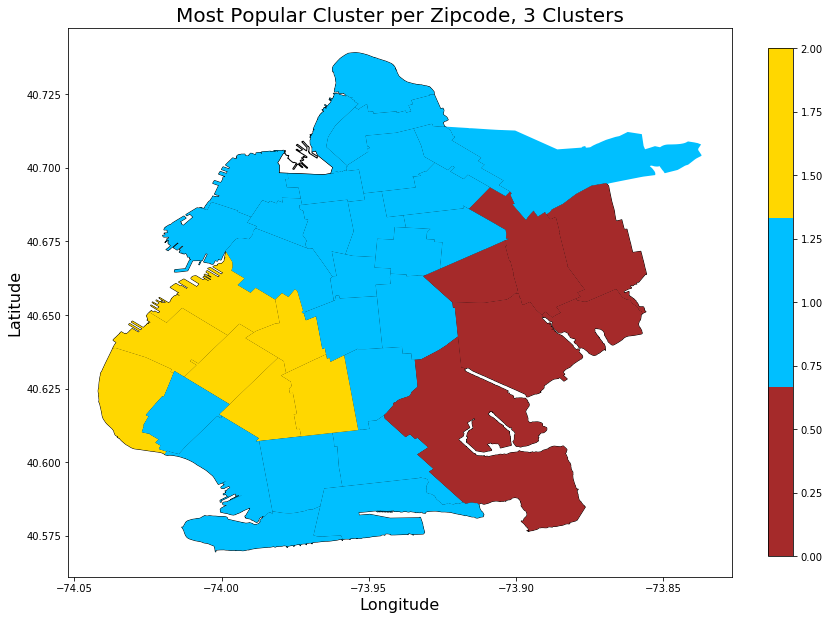

In [561]:
# Plot most frequently appearing cluster label per zip

color3 = ['brown', 'deepskyblue', 'gold']

fig, ax = plt.subplots(figsize = (13, 13))
gdf[gdf['COUNTY'] == 'Kings'].plot(ax=ax, color='white', edgecolor='black')
gdf_clusters3.plot('CLUSTER', legend = True, ax=ax,  # All df columns are identical
             cmap = mcolors.ListedColormap(color3), legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0, vmax = 2)

                  
ax.set_title('Most Popular Cluster per Zipcode, 3 Clusters', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

**Note:** k-modes assigns a cluster to each data point. All data points in a zipcode do not necessarily appear in the same cluster. In fact, a single zipcode will usually have data points assigned to a number of different clusters. This map shows the most frequently appearing cluster for a given zipcode. For n=3 clusters, there seems to be very little differentiation within the borough of Brooklyn, since most zipcodes have the most incidents assigned to `cluster 1`.

#### n_clusters = 10

In [376]:
# Credit to https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae
# and https://pypi.org/project/kmodes/

# define the k-modes model
km = KModes(n_clusters=10, init='Huang', n_init=11, verbose=1)

# fit the clusters to the skills dataframe
clusters = km.fit_predict(X)
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape
# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.
# If no "1" appears, assign to "no-skills" cluster.
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in X.columns[np.nonzero(cent)]:
            print(j)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5205, cost: 43668.0
Run 1, iteration: 2/100, moves: 0, cost: 43668.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6321, cost: 40220.0
Run 2, iteration: 2/100, moves: 97, cost: 40220.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5073, cost: 42044.0
Run 3, iteration: 2/100, moves: 11, cost: 42044.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2474, cost: 45923.0
Run 4, iteration: 2/100, moves: 99, cost: 45923.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 5828, cost: 39589.0
Run 5, iteration: 2/100, moves: 731, cost: 39158.0
Run 5, iteration: 3/100, moves: 888, cost: 38809.0
Run 5, iteration: 4/100, moves: 402, co

In [384]:
# Create new column in the 
df_canceled_bk['CLUSTER10'] = km.labels_

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [385]:
df_canceled_bk

,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH_BINNED,CLUSTER
CAD_INCIDENT_ID,,,,,,
183654152,RESPIR,BROOKLYN,K7,11221,"(22.5, 30.0]",7
183654073,UNC,BROOKLYN,K4,11236,"(12.5, 15.0]",3
183653977,UNKNOW,BROOKLYN,K1,11210,"(10.0, 12.5]",6
183653901,PEDSTR,BROOKLYN,K4,11236,"(15.0, 22.5]",3
183653875,UNKNOW,BROOKLYN,K6,11231,"(0.0, 5.0]",9
...,...,...,...,...,...,...
130023191,DRUG,BROOKLYN,K7,11207,"(10.0, 12.5]",7
130015308,CARD,BROOKLYN,K4,11234,"(0.0, 5.0]",8
130015132,STATEP,BROOKLYN,K2,11226,"(7.5, 10.0]",2


In [408]:
len(set(df_canceled_bk['ZIPCODE']))

39

In [390]:
bk_cluster_agg = df_canceled_bk.groupby(['ZIPCODE','CLUSTER10']).count().reset_index()

In [410]:
bk_cluster_agg.head(6)

,ZIPCODE,CLUSTER,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,CALL_LENGTH_BINNED
0,11201,0,80,80,80,80
1,11201,2,2,2,2,2
2,11201,3,1,1,1,1
3,11201,5,40,40,40,40
4,11201,6,2,2,2,2
5,11201,9,303,303,303,303


In [432]:
# With assistance from Noah C

list_cluster = []
list_zip = []
for zipcode in set(bk_cluster_agg['ZIPCODE']):
    zip_max_calls = np.max(bk_cluster_agg[bk_cluster_agg['ZIPCODE'] == zipcode]['INITIAL_CALL_TYPE'])
    max_cluster =  bk_cluster_agg[(bk_cluster_agg['ZIPCODE']==zipcode) & (bk_cluster_agg['INITIAL_CALL_TYPE'] == zip_max_calls)]['CLUSTER10'].values[0]
    list_cluster.append(max_cluster)
    list_zip.append(zipcode)
    
df_cluster10 = pd.DataFrame({
    'ZIPCODE' : list_zip,
    'CLUSTER' : list_cluster
})


In [434]:
df_cluster10.head()

,ZIPCODE,CLUSTER
0,11201,9
1,11203,4
2,11204,2
3,11205,9
4,11206,7


#### Map results

In [435]:
# merge my clusters with the zipcodes df
# Aaaaand merge the dataframes, at long last!
merged_bkclusters10 = pd.merge(df_cluster10, gdf, how = 'left', on = 'ZIPCODE')

In [440]:
merged_bkclusters10.head()

,ZIPCODE,CLUSTER,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11201,9,0,Brooklyn,53041.0,4.109489e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97869 40.70545, -73.97878 40.705..."
1,11203,4,0,Brooklyn,78060.0,6.064484e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94270 40.66405, -73.94153 40.663..."
2,11204,2,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98108 40.63529, -73.98095 40.635..."
3,11205,9,0,Brooklyn,41125.0,2.327015e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95335 40.69934, -73.95292 40.697..."
4,11206,7,0,Brooklyn,83575.0,4.070072e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93241 40.70797, -73.93231 40.707..."


In [439]:
# Create GeoPandas DataFrame from merged df and its associated geometry column
gdf_clusters10 = gpd.GeoDataFrame(merged_bkclusters10, geometry = merged_bkclusters10.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

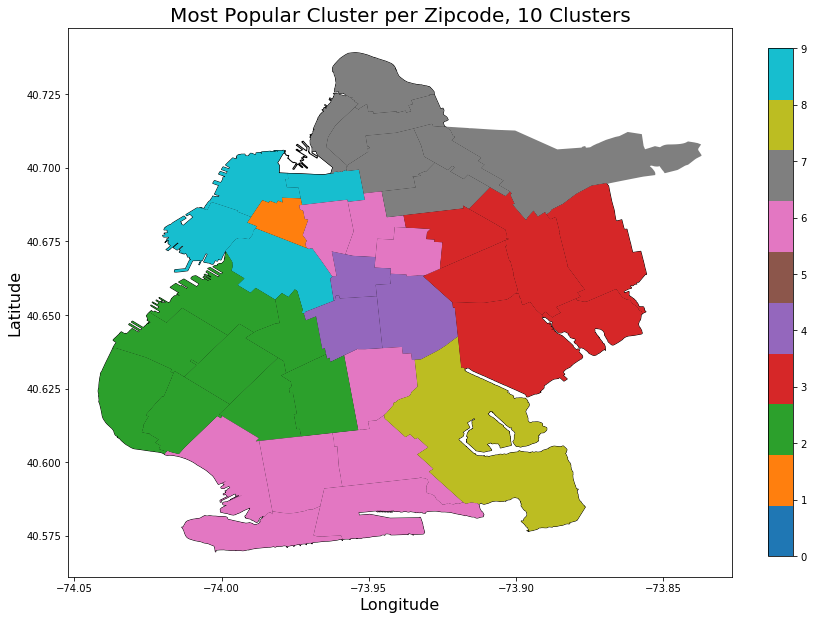

In [456]:
# Plot ratio of canceled calls per zip
fig, ax = plt.subplots(figsize = (13, 13))
gdf[gdf['COUNTY'] == 'Kings'].plot(ax=ax, color='white', edgecolor='black')
gdf_clusters10.plot('CLUSTER10', legend=True, ax=ax,  # All df columns are identical
             cmap = 'tab10', legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0, vmax = 9)
                  
ax.set_title('Most Popular Cluster per Zipcode, 10 Clusters', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

**Notes:** 

In [135]:
km.cluster_centroids_[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

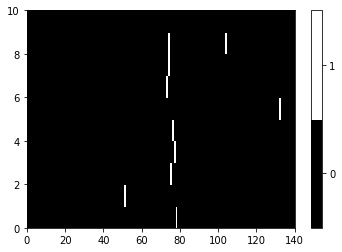

In [152]:
import matplotlib.colors as mcolors
cmap = plt.get_cmap('bone')
norm = mcolors.BoundaryNorm([0,0.5, 1], cmap.N)
im = plt.pcolormesh(km.cluster_centroids_, cmap=cmap, norm=norm)
cb = plt.colorbar(im)
cb.set_ticks([0.25, .75])
cb.set_ticklabels([0,1])

#### n_clusters = 12

In [496]:
# define the k-modes model
km = KModes(n_clusters=12, init='Huang', n_init=11, verbose=1)

# fit the clusters to the skills dataframe
clusters = km.fit_predict(X)

# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape

# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.
# If no "1" appears, assign to "no-skills" cluster.
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in X.columns[np.nonzero(cent)]:
            print(j)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6814, cost: 39980.0
Run 1, iteration: 2/100, moves: 365, cost: 39980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7177, cost: 39647.0
Run 2, iteration: 2/100, moves: 589, cost: 39647.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3700, cost: 40162.0
Run 3, iteration: 2/100, moves: 46, cost: 40162.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4604, cost: 40648.0
Run 4, iteration: 2/100, moves: 476, cost: 40648.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1381, cost: 44542.0
Run 5, iteration: 2/100, moves: 0, cost: 44542.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, i

In [497]:
# Create new column in the 
df_canceled_bk['CLUSTER12'] = km.labels_

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [498]:
df_canceled_bk

,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH_BINNED,CLUSTER,CLUSTER3,CLUSTER12
CAD_INCIDENT_ID,,,,,,,,
183654152,RESPIR,BROOKLYN,K7,11221,"(22.5, 30.0]",1,1,9
183654073,UNC,BROOKLYN,K4,11236,"(12.5, 15.0]",0,0,0
183653977,UNKNOW,BROOKLYN,K1,11210,"(10.0, 12.5]",1,1,0
183653901,PEDSTR,BROOKLYN,K4,11236,"(15.0, 22.5]",0,0,1
183653875,UNKNOW,BROOKLYN,K6,11231,"(0.0, 5.0]",1,1,8
...,...,...,...,...,...,...,...,...
130023191,DRUG,BROOKLYN,K7,11207,"(10.0, 12.5]",1,1,9
130015308,CARD,BROOKLYN,K4,11234,"(0.0, 5.0]",0,0,0
130015132,STATEP,BROOKLYN,K2,11226,"(7.5, 10.0]",1,1,4


In [499]:
len(set(df_canceled_bk['ZIPCODE']))

39

In [500]:
bk_cluster_agg = df_canceled_bk.groupby(['ZIPCODE','CLUSTER12']).count().reset_index()

In [501]:
bk_cluster_agg.head(6)

,ZIPCODE,CLUSTER12,INITIAL_CALL_TYPE,BOROUGH,INCIDENT_DISPATCH_AREA,CALL_LENGTH_BINNED,CLUSTER,CLUSTER3
0,11201,0,2,2,2,2,2,2
1,11201,2,79,79,79,79,79,79
2,11201,3,1,1,1,1,1,1
3,11201,4,2,2,2,2,2,2
4,11201,6,59,59,59,59,59,59
5,11201,7,40,40,40,40,40,40


In [502]:
# With assistance from Noah C

list_cluster = []
list_zip = []
for zipcode in set(bk_cluster_agg['ZIPCODE']):
    zip_max_calls = np.max(bk_cluster_agg[bk_cluster_agg['ZIPCODE'] == zipcode]['INITIAL_CALL_TYPE'])
    max_cluster =  bk_cluster_agg[(bk_cluster_agg['ZIPCODE']==zipcode) & (bk_cluster_agg['INITIAL_CALL_TYPE'] == zip_max_calls)]['CLUSTER12'].values[0]
    list_cluster.append(max_cluster)
    list_zip.append(zipcode)
    
df_cluster12 = pd.DataFrame({
    'ZIPCODE' : list_zip,
    'CLUSTER' : list_cluster
})


In [504]:
df_cluster12.head()

,ZIPCODE,CLUSTER
0,11201,8
1,11203,10
2,11204,4
3,11205,8
4,11206,9


#### Map results

In [505]:
# merge my clusters with the zipcodes df
# Aaaaand merge the dataframes, at long last!
merged_bkclusters12 = pd.merge(df_cluster12, gdf, how = 'left', on = 'ZIPCODE')

In [506]:
merged_bkclusters12.head()

,ZIPCODE,CLUSTER,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11201,8,0,Brooklyn,53041.0,4.109489e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97869 40.70545, -73.97878 40.705..."
1,11203,10,0,Brooklyn,78060.0,6.064484e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94270 40.66405, -73.94153 40.663..."
2,11204,4,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98108 40.63529, -73.98095 40.635..."
3,11205,8,0,Brooklyn,41125.0,2.327015e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95335 40.69934, -73.95292 40.697..."
4,11206,9,0,Brooklyn,83575.0,4.070072e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93241 40.70797, -73.93231 40.707..."


In [507]:
# Create GeoPandas DataFrame from merged df and its associated geometry column
gdf_clusters12 = gpd.GeoDataFrame(merged_bkclusters12, geometry = merged_bkclusters12.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

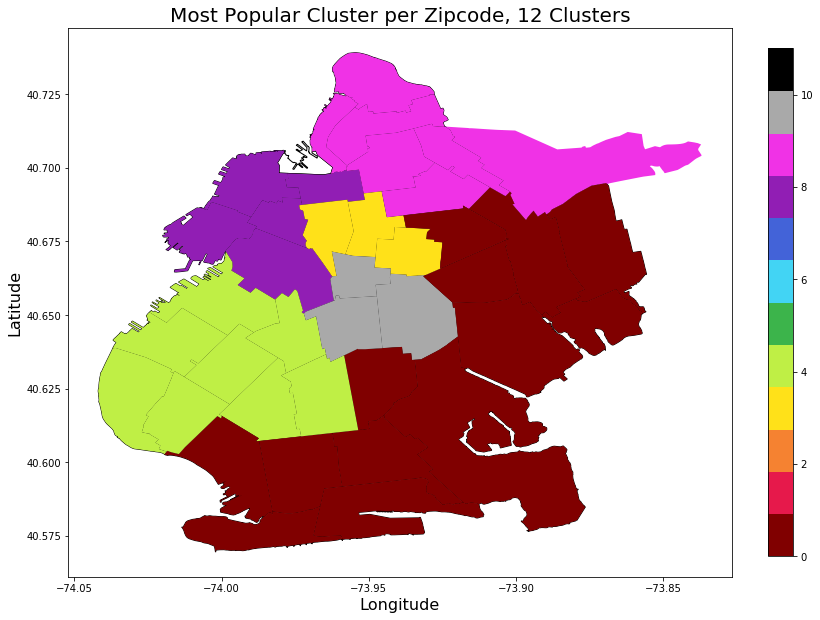

In [512]:
# Plot most frequently appearing cluster label per zip

color12 = ['#800000', '#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b',
          '#42d4f4', '#4363d8', '#911eb4', '#f032e6', '#a9a9a9', '#000000']

fig, ax = plt.subplots(figsize = (13, 13))
gdf[gdf['COUNTY'] == 'Kings'].plot(ax=ax, color='white', edgecolor='black')
gdf_clusters12.plot('CLUSTER', legend = True, ax=ax,  # All df columns are identical
             cmap = mcolors.ListedColormap(color12), legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0, vmax = 11)

                  
ax.set_title('Most Popular Cluster per Zipcode, 12 Clusters', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()